# VolSense Notebook 02 — Model Training & Evaluation

## 1️⃣ Notebook Overview

This notebook demonstrates how to train and evaluate all VolSense model families on the same prepared dataset from `01_data_preparation.ipynb`, using a single high-level API:

- **GARCH family**: GARCH(1,1), EGARCH, GJR-GARCH (ticker-wise, statistical baselines)

- **BaseLSTM**: per-ticker neural model that learns non-linear temporal patterns

- **GlobalVolForecaster** (Global LSTM): a shared model trained across all tickers that captures cross-sectional structure (e.g., sector behaviors, regime coupling)

We also standardize evaluation using `evaluation.ModelEvaluator` to report:

- Error metrics (RMSE/MAE/MAPE), bias, Durbin-Watson (residual auto-correlation),

- True vs predicted correlations per horizon,

- Best & worst performing tickers,

- QQ/residual diagnostics, and (if available) feature importance.

## 2️⃣ Imports & Paths

In [ ]:
import os
import pandas as pd

# Core VolSense APIs
from volsense_core.forecaster_core import VolSenseForecaster
from volsense_core.evaluation.evaluation import ModelEvaluator

# Paths (align these with Notebook 01 outputs)
DATA_PATH  = "../data/processed/global_volatility_dataset.csv"  # same file saved in 01_data_preparation
MODELS_DIR = "models/base_lstm/"
os.makedirs(MODELS_DIR, exist_ok=True)

pd.set_option("display.max_columns", 120)

## 3️⃣ Load Prepared Dataset:

We load the multi-ticker DataFrame prepared in the previous notebook. We also make an "AAPL" subset df for single-ticker model training.

In [5]:
multi_df = pd.read_csv(DATA_PATH, parse_dates=["date"])
print(f"✅ Loaded {len(multi_df):,} rows across {multi_df['ticker'].nunique()} tickers")

aapl_df = multi_df[multi_df['ticker'] == 'AAPL'].copy()
print(f"✅ AAPL subset has {len(aapl_df):,} rows")
display(aapl_df.head())

✅ Loaded 13,530 rows across 5 tickers
✅ AAPL subset has 2,706 rows


,date,return,realized_vol,ticker,realized_vol_log,ret_sq,vol_vol,abs_return,vol_chg,day_of_week,vol_10d,month_sin,skew_5d,month_cos,market_stress_1d_lag,vol_ratio,vol_3d,market_stress,ewma_vol_10d
0,2015-01-26,0.001062,0.308936,AAPL,-1.174619,0.000001,NaN,0.001062,0.000000,0.000000,0.308936,0.5,NaN,0.866025,NaN,0.999997,0.308936,0.003203,0.308936
1,2015-01-27,-0.035013,0.322128,AAPL,-1.132802,0.001226,0.009329,0.035013,0.000000,0.166667,0.315532,0.5,NaN,0.866025,0.003203,0.999997,0.315532,0.031067,0.311334
2,2015-01-28,0.056533,0.391718,AAPL,-0.937211,0.003196,0.044478,0.056533,0.000000,0.333333,0.340927,0.5,0.252498,0.866025,0.031067,0.999997,0.340927,0.034822,0.325949
3,2015-01-29,0.031134,0.404302,AAPL,-0.905590,0.000969,0.048197,0.031134,0.015945,0.500000,0.356771,0.5,-0.187521,0.866025,0.034822,1.044690,0.372716,0.008002,0.340195
4,2015-01-30,-0.014634,0.387965,AAPL,-0.946838,0.000214,0.044009,0.014634,0.031652,0.666667,0.363010,0.5,0.220787,0.866025,0.008002,1.087190,0.394662,0.010712,0.348881


## 5️⃣ Architecture Notes: **BaseLSTM**

- **Design goals**
  - Learn non-linear temporal patterns in volatility that GARCH can’t capture.
  - Train a separate model (or separate per-ticker streams) so each ticker’s history is learned with its own idiosyncrasies.

- **Input window**
  - Slide a look-back window of length `window` (e.g., 30–60 days).
  - The model consumes:
    - Canonical return series
    - Optional `extra_features` (engineered features that summarize volatility behavior: short/long vol means, ratios, EWMA, skew, stress)

- **Architecture sketch**
  - 1–3 stacked **LSTM** layers with hidden size `hidden_dim` and dropout to reduce overfit
  - Multi-horizon **heads** (e.g., 1/5/10-day vol) predicted from the final hidden state (or a small MLP on top)

- **Key knobs**
  - `window`: sequence length (how far back the model “sees”)
  - `horizons`: target forecast horizons (list of ints)
  - `epochs`, `lr`, `dropout`, `hidden_dim`, `num_layers`
  - `extra_features`: list of engineered columns to include (must exist in `df_feat`)

- **Trade-offs**
  - Strong at learning idiosyncratic patterns; may overfit if features are too many vs data size
  - No explicit sharing across tickers → less cross-sectional generalization than the global model

## 6️⃣ Train BaseLSTM

We call the multi-model wrapper object **`VolSenseForecaster()`** with `method` = "lstm". A full set of knobs, features and architectural details on BaseLSTM can be accessed by going to the `lstm_forecaster.py` file, or the documentation.

VolSenseForecaster.fit trains the model based on the input dataframe (our single-ticker AAPL dataframe in this case)

In [ ]:

extra_feats = [
    "vol_3d", "vol_10d", "vol_ratio", "vol_chg", "ewma_vol_10d",
    "market_stress", "market_stress_1d_lag",
    "skew_5d", "day_of_week", "month_sin", "month_cos",
    "abs_return", "ret_sq"
                ]

lstm_forecaster = VolSenseForecaster(
    method="lstm",
    window=40,
    horizons=[1, 5, 10],
    epochs=15,
    lr=5e-4,
    dropout=0.15,
    hidden_dim=128,
    num_layers=2,
    device="cpu",
    extra_features=extra_feats,
)

lstm_model = lstm_forecaster.fit(aapl_df) # lstm_model is stored as the model object
print("✅ BaseLSTM training complete.")

🧩 Training BaseLSTM Forecaster...
Epoch 1/15 | LR: 4.95e-04 | Train: 0.797066 | Val: 0.582280
Epoch 2/15 | LR: 4.78e-04 | Train: 0.519073 | Val: 0.510542
Epoch 3/15 | LR: 4.52e-04 | Train: 0.431675 | Val: 0.467682
Epoch 4/15 | LR: 4.17e-04 | Train: 0.387894 | Val: 0.408617
Epoch 5/15 | LR: 3.75e-04 | Train: 0.343138 | Val: 0.416573
Epoch 6/15 | LR: 3.28e-04 | Train: 0.303664 | Val: 0.431756
Epoch 7/15 | LR: 2.77e-04 | Train: 0.282760 | Val: 0.410697
Epoch 8/15 | LR: 2.24e-04 | Train: 0.266401 | Val: 0.369373
Epoch 9/15 | LR: 1.73e-04 | Train: 0.266598 | Val: 0.382464
Epoch 10/15 | LR: 1.26e-04 | Train: 0.247396 | Val: 0.385229
Epoch 11/15 | LR: 8.36e-05 | Train: 0.227404 | Val: 0.378933
Epoch 12/15 | LR: 4.87e-05 | Train: 0.221877 | Val: 0.344782
Epoch 13/15 | LR: 2.26e-05 | Train: 0.211444 | Val: 0.339918
Epoch 14/15 | LR: 6.45e-06 | Train: 0.213504 | Val: 0.346067
Epoch 15/15 | LR: 1.00e-06 | Train: 0.209790 | Val: 0.345947
✅ BaseLSTM training complete.


## 7️⃣ Architecture Notes: GlobalVolForecaster

- **Design goals**
  - Train ****one shared model** over **all tickers** → learns both **temporal patterns** and **cross-sectional structure** (sector behaviors, co-movements, regime coupling).
  - Accelerate learning by pooling data; improve generalization for sparse tickers.

- **Input representation**
  - Same window and extra_features as BaseLSTM, but now **aggregated across all tickers**.
  - Many global architectures include a ticker embedding or normalized per-ticker scalers; your training code handles that internally.

- **Key knobs**
  - Same as BaseLSTM: `window`, `horizons`, `epochs`, `lr`, `dropout`, `hidden_dim`, `num_layers`, `extra_features`.

- **Trade-offs**
  - Stronger **sample efficiency** and **generalization**.
  - May slightly underfit idiosyncratic extremes vs a per-ticker specialist if features are not rich enough.

## 8️⃣ Train GlobalVolForecaster

For the purposes of saving time, the below example trains on only the 5 tickers from the `multi_df` we generated in the previous notebook (~12 mins training time). The model more often than not improves and generalizes with more tickers + epochs.

In [ ]:
global_forecaster = VolSenseForecaster(
    method="global_lstm",
    window=40,
    horizons=[1, 5, 10],
    epochs=25,
    lr=5e-4,
    dropout=0.2,
    hidden_dim=128,
    num_layers=3,
    device="cpu",
    extra_features=extra_feats,
) # global model instance

global_model = global_forecaster.fit(multi_df) # global_model is stored as the model object
print("✅ GlobalVolForecaster training complete.")

🌐 Training GlobalVolForecaster...

🚀 Training GlobalVolForecaster on 5 tickers...

Epoch 1/25| LR: 3.0000e-04 |  Train Loss: 0.3974 | Val Loss: 0.1664
Epoch 2/25| LR: 2.7997e-04 |  Train Loss: 0.1939 | Val Loss: 0.1344
Epoch 3/25| LR: 2.2525e-04 |  Train Loss: 0.1635 | Val Loss: 0.1226
Epoch 4/25| LR: 1.5050e-04 |  Train Loss: 0.1533 | Val Loss: 0.1231
Epoch 5/25| LR: 7.5750e-05 |  Train Loss: 0.1460 | Val Loss: 0.1220
Epoch 6/25| LR: 2.1029e-05 |  Train Loss: 0.1416 | Val Loss: 0.1155
Epoch 7/25| LR: 3.0000e-04 |  Train Loss: 0.1362 | Val Loss: 0.1103
Epoch 8/25| LR: 2.7997e-04 |  Train Loss: 0.1361 | Val Loss: 0.1213
Epoch 9/25| LR: 2.2525e-04 |  Train Loss: 0.1376 | Val Loss: 0.1051
Epoch 10/25| LR: 1.5050e-04 |  Train Loss: 0.1216 | Val Loss: 0.0946
Epoch 11/25| LR: 7.5750e-05 |  Train Loss: 0.1119 | Val Loss: 0.0910
Epoch 12/25| LR: 2.1029e-05 |  Train Loss: 0.1015 | Val Loss: 0.0844
Epoch 13/25| LR: 3.0000e-04 |  Train Loss: 0.0996 | Val Loss: 0.0848
Epoch 14/25| LR: 2.7997e-04 |

: 

## 9️⃣ Architecture Notes: GARCH Family

- **GARCH(1,1)**
    - Models conditional variance as a function of last period’s variance and last shock.

- **EGARCH**
    - Models log variance, allowing asymmetric responses to positive vs negative shocks.

- **GJR-GARCH**
    - Adds an indicator for negative shocks (leverage effect). Useful in equities where downside shocks dominate.

- **Key knobs**

    - Usually you don’t need to specify (p,q); defaults are chosen inside VolSenseForecaster.

- **Pros**: interpretable, fast.

- **Cons**: linear, can’t exploit engineered features or cross-ticker structure.

## 🔟 Train GARCH, EGARCH, GJR

GARCH family models currently only support 1-day rolling forecasts using `predict()` since 5 and 10-day forecasts are very computationally intensive.

In [9]:
garch_forecaster = VolSenseForecaster(method="garch",  horizons=[1, 5, 10])
garch_model = garch_forecaster.fit(multi_df)
print("✅ GARCH model training complete.")

egarch_forecaster = VolSenseForecaster(method="egarch", horizons=[1, 5, 10])
egarch_model = egarch_forecaster.fit(multi_df)
print("✅ EGARCH model training complete.")

gjr_forecaster = VolSenseForecaster(method="gjr", horizons=[1, 5, 10])
gjr_model = gjr_forecaster.fit(multi_df)
print("✅ GJR model training complete.")

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AAPL (2706 obs).
✅ GARCH model training complete.
📈 Fitting EGARCH Forecaster...
✅ EGARCH fit complete for AAPL (2706 obs).
✅ EGARCH model training complete.
📈 Fitting GJR Forecaster...
✅ GJR fit complete for AAPL (2706 obs).
✅ GJR model training complete.


## 1️⃣1️⃣ Shared Model Evaluator

The **`ModelEvaluator`** object is a powerful and flexible tool to evaluate and backtest the performance of any of the three model classes.

`VolSenseForecaster.predict()` produces and stores a dataframe of predicted vs. realized volatilities. `predict()` has two modes: 'eval' (returns past predictions), and 'inference' (returns future predictions). When the eval dataframe (along with the training data) are passed to `ModelEvaluator`, you get a detailed set of evaluation tools, including:

- **Error metrics**
  - RMSE, MAE, MAPE, bias, R² score
- **Autocorrelation**
  - Durbin–Watson (DW), acf_sum_k10
- **Residual diagnostics**
  - Residual distribution plots
  - QQ-plots
- **Feature importance (optional)**
  - evaluation.py mentions feature importance as “if available.” If your model exposes importance (e.g., attention weights) or you add a permutation-importance helper in `ModelEvaluator`, you can call it after computing metrics.

(Please note that this is a demo notebook and does not reflect the peak performance of these models. To reach their full potential requires extensive trial-and-error with hyperparameter tuning and feature selection)

## 1️⃣2️⃣ Shared Evaluation Settings + Gather Predictions

In [11]:
EVAL_HORIZONS = [1, 5, 10]
TARGET_COL    = "realized_vol"
Y_IS_LOG      = False
WINDOW_USED   = 40

baselstm_preds = lstm_model.predict(data=aapl_df, mode="eval")
print("✅ BaseLSTM predictions generated.")
global_preds   = global_model.predict(data=multi_df, mode="eval")
print("✅ GlobalVolForecaster predictions generated.")
garch_preds    = garch_model.predict(data=multi_df, mode="eval")
print("✅ GARCH predictions generated.")
egarch_preds   = egarch_model.predict(data=multi_df, mode="eval")
print("✅ EGARCH predictions generated.")
gjr_preds      = gjr_model.predict(data=multi_df, mode="eval")
print("✅ GJR predictions generated.")

✅ BaseLSTM predictions generated.


Rolling eval forecasts: 100%|██████████| 5/5 [04:28<00:00, 53.70s/it]


✅ GlobalVolForecaster realized-aligned evaluation complete (39925 rows).
✅ GlobalVolForecaster predictions generated.
✅ GARCH predictions generated.
✅ EGARCH predictions generated.
✅ GJR predictions generated.


## 1️⃣3️⃣ Evaluate all models

Initiate the `ModelEvaluator` objects:

In [13]:
baselstm_evaluator = ModelEvaluator(
    eval_df=baselstm_preds,
    model_name="BaseLSTM",
)

global_evaluator = ModelEvaluator(
    eval_df=global_preds,
    model_name="GlobalVolForecaster",
)

garch_evaluator = ModelEvaluator(
    eval_df=garch_preds,
    model_name="GARCH",
)

egarch_evaluator = ModelEvaluator(
    eval_df=egarch_preds,
    model_name="EGARCH",
)

gjr_evaluator = ModelEvaluator(
    eval_df=gjr_preds,
    model_name="GJR",
)

## 1️⃣4️⃣ `ModelEvaluator` — method calls

- Metrics
  - `evaluator.compute_metrics()`

- Diagnostics and plots
  - `evaluator.plot_residuals()`
  - `evaluator.plot_qq()`
  - `evaluator.plot_true_vs_pred()`

- One-shot
  - `evaluator.run_full_evaluation()`

- Optional (if implemented)
  - evaluator.plot_feature_importance(top_n=15)
  - evaluator.permutation_importance(df=multi_df, features=extra_feats, horizon=5)


🚀 Running full evaluation for BaseLSTM

📈 Horizon-Level Summary for BaseLSTM


,horizon,RMSE,MAE,MAPE,R2,Corr,DW
0,1,0.0642,0.0478,3.6770,0.8940,0.9558,0.4656
1,5,0.1191,0.0678,4.9467,0.6351,0.8398,0.2163
2,10,0.1820,0.0946,6.7817,0.1474,0.5348,0.1000


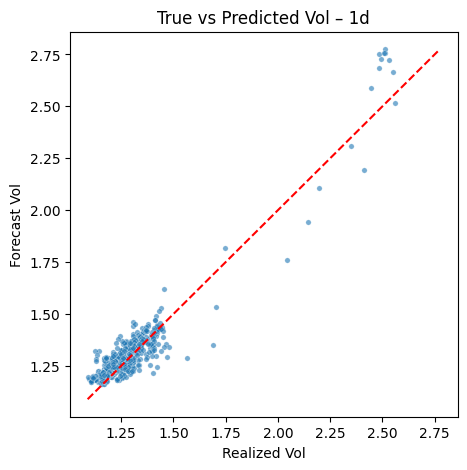

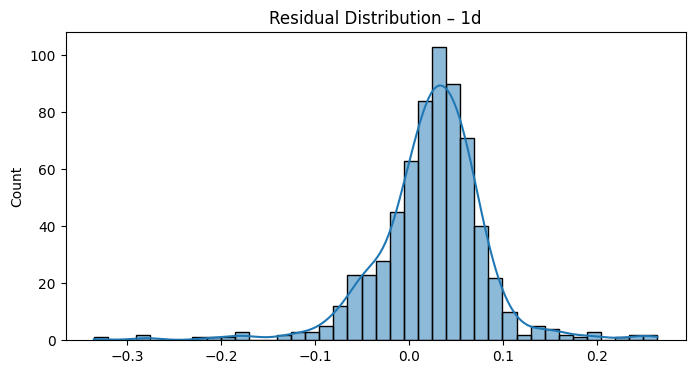

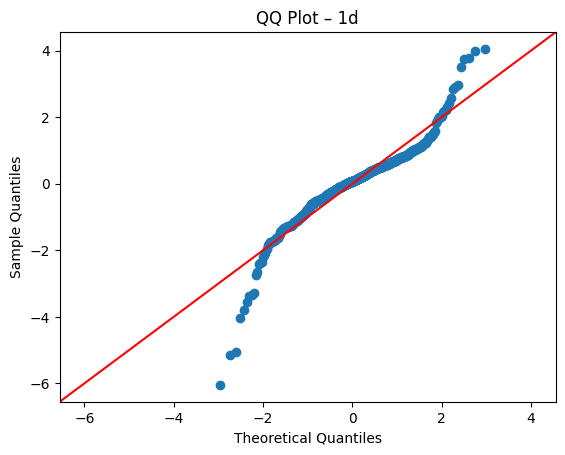

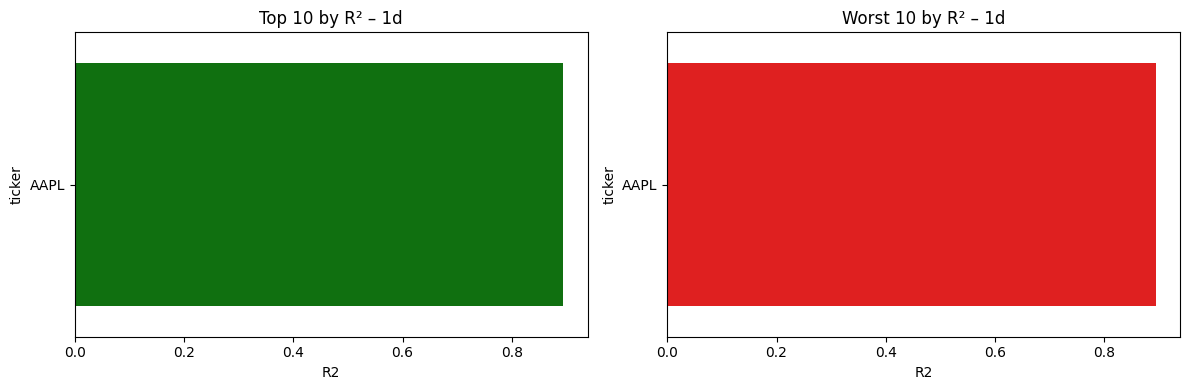

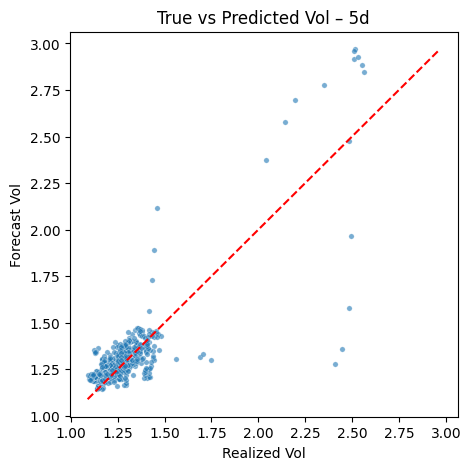

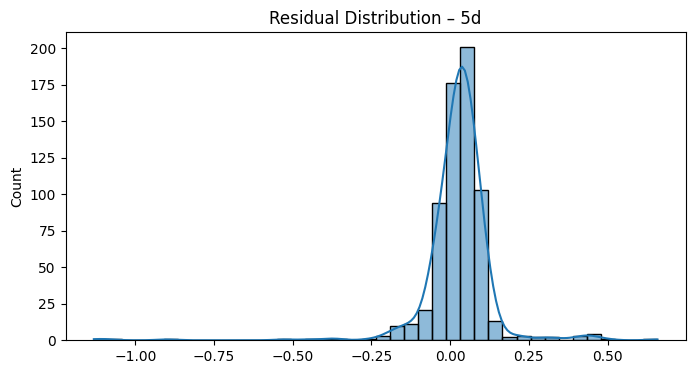

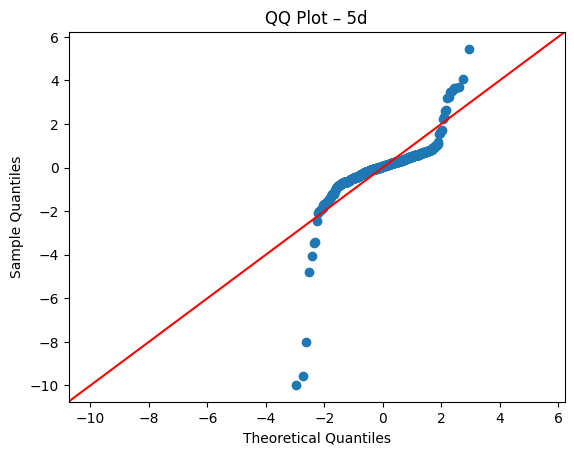

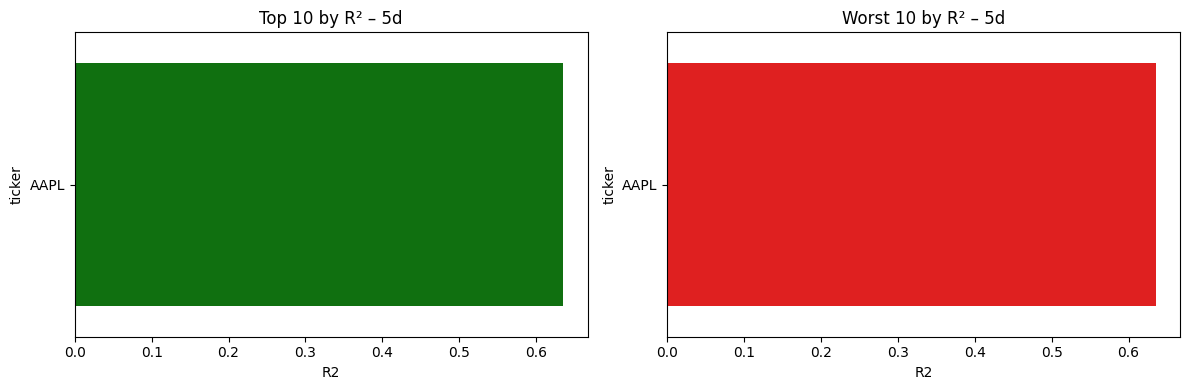

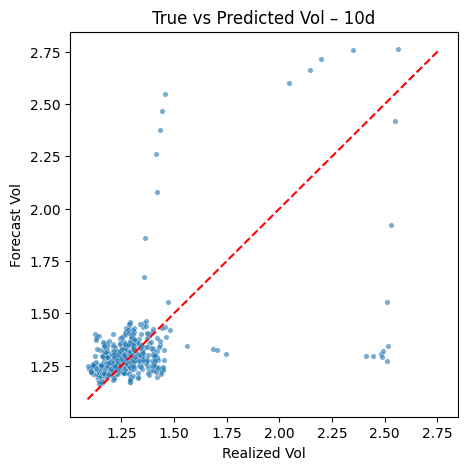

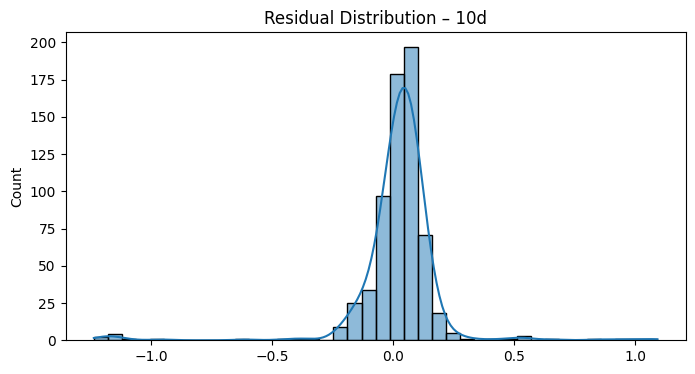

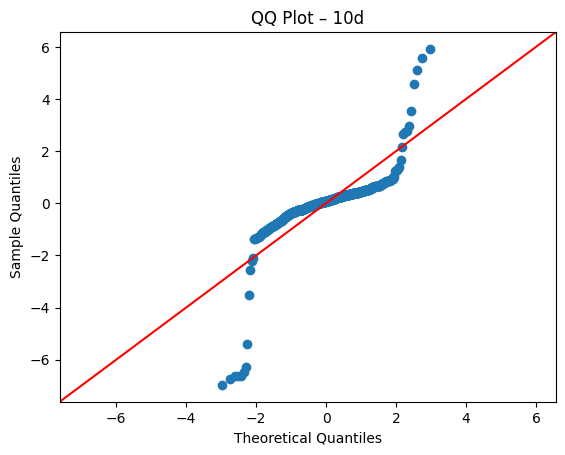

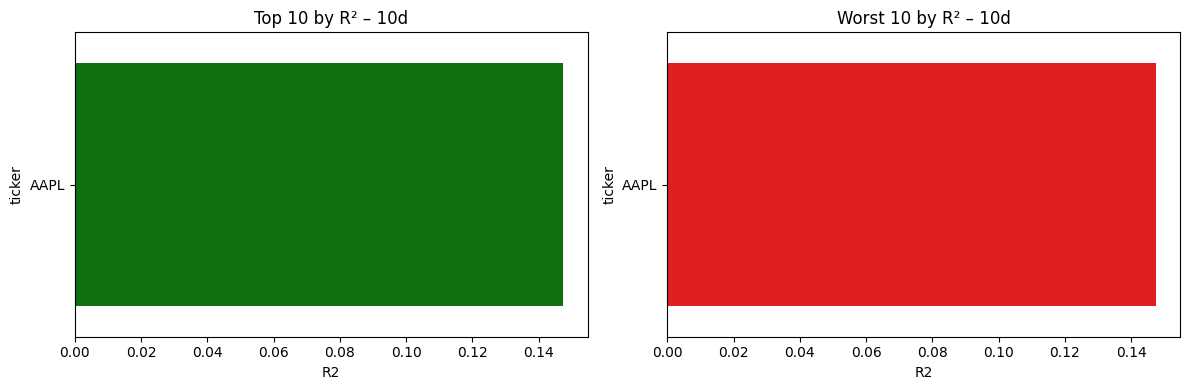

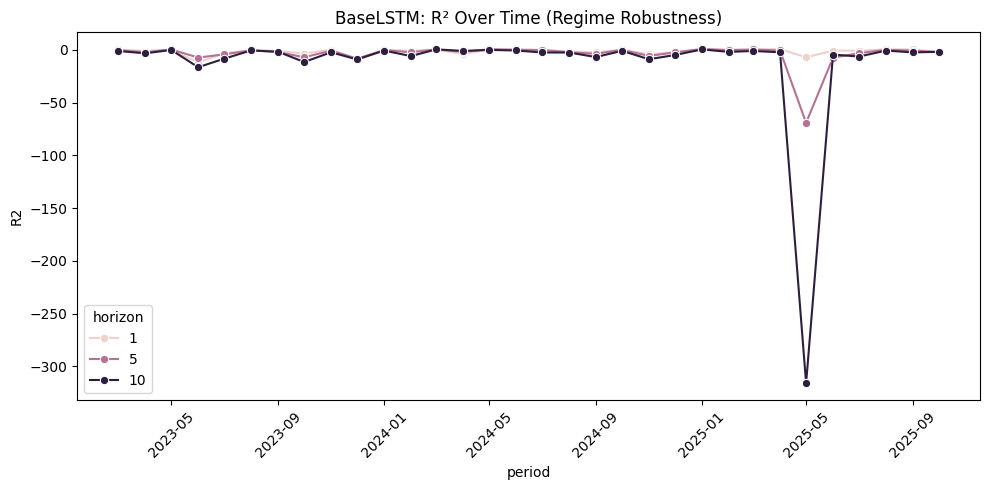

✅ Evaluation complete.


(  ticker  horizon      RMSE       MAE      MAPE        R2      Corr        DW  \
 0   AAPL        1  0.064158  0.047833  3.676952  0.893986  0.955830  0.465572   
 1   AAPL        5  0.119056  0.067769  4.946676  0.635089  0.839820  0.216306   
 2   AAPL       10  0.181994  0.094587  6.781688  0.147409  0.534819  0.099969   
 
    ACF_SumSq  
 0   0.977719  
 1   1.738597  
 2   2.985815  ,
    horizon      RMSE       MAE      MAPE        R2      Corr        DW
 0        1  0.064158  0.047833  3.676952  0.893986  0.955830  0.465572
 1        5  0.119056  0.067769  4.946676  0.635089  0.839820  0.216306
 2       10  0.181994  0.094587  6.781688  0.147409  0.534819  0.099969,
     horizon     period         R2      Corr      RMSE
 0         1 2023-03-01   0.038702  0.225522  0.035424
 1         1 2023-04-01  -0.765644  0.540279  0.030004
 2         1 2023-05-01  -0.002775  0.416689  0.049205
 3         1 2023-06-01 -11.905362 -0.588200  0.030624
 4         1 2023-07-01  -3.211081 -0.573

In [14]:
# Evaluate BaseLSTM model

baselstm_evaluator.run_full_evaluation()


🚀 Running full evaluation for GlobalVolForecaster

📈 Horizon-Level Summary for GlobalVolForecaster


,horizon,RMSE,MAE,MAPE,R2,Corr,DW
0,1,0.0782,0.0548,20.3708,0.7486,0.8851,0.2096
1,5,0.0930,0.0637,23.5753,0.6494,0.8133,0.1505
2,10,0.1228,0.0844,31.7137,0.3815,0.6340,0.0869


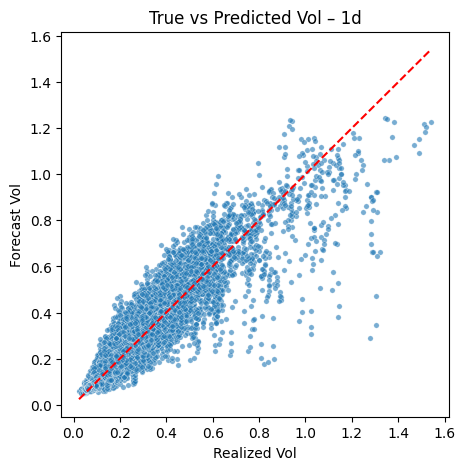

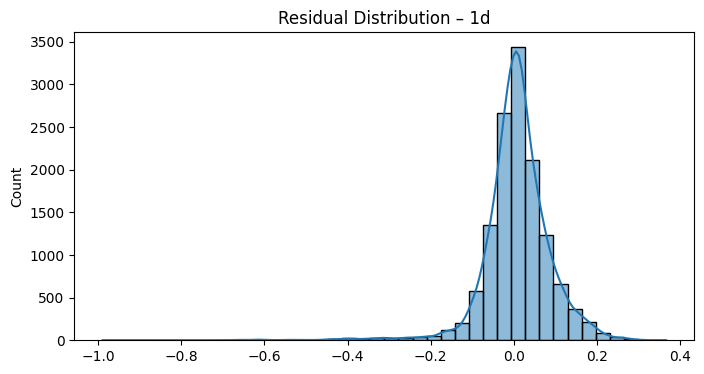

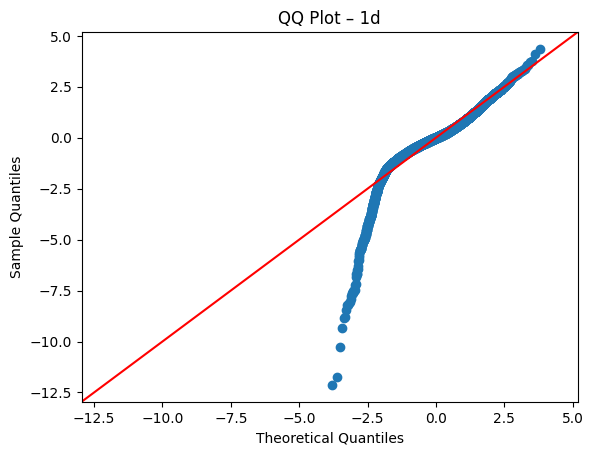

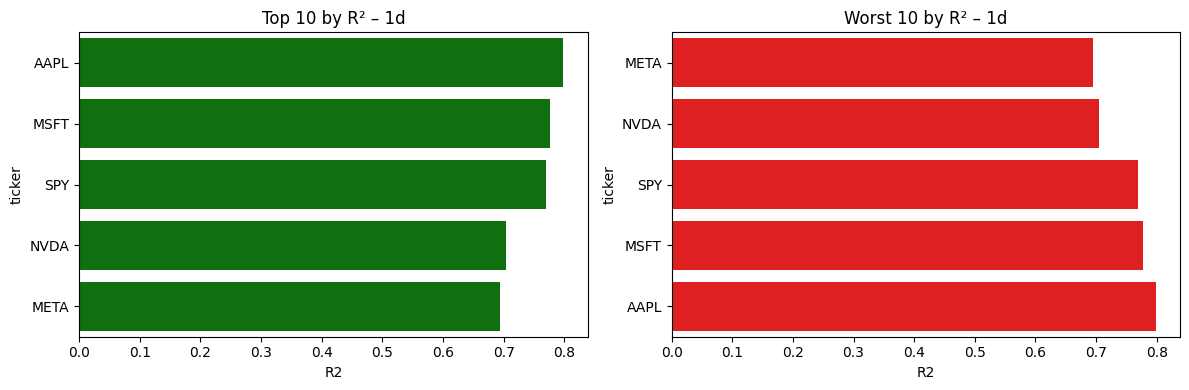

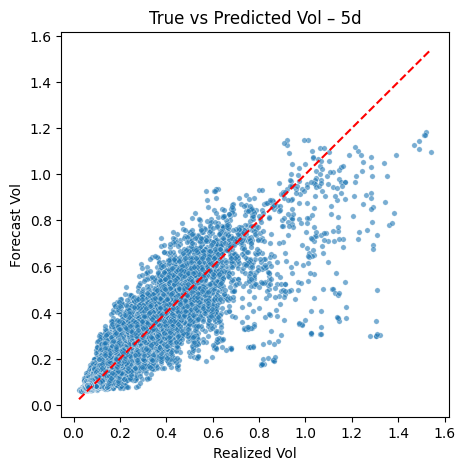

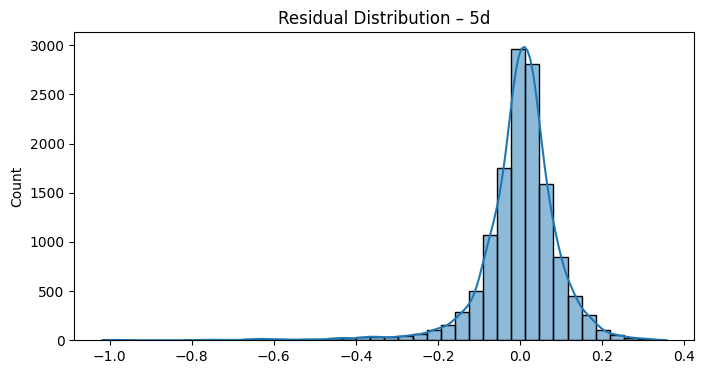

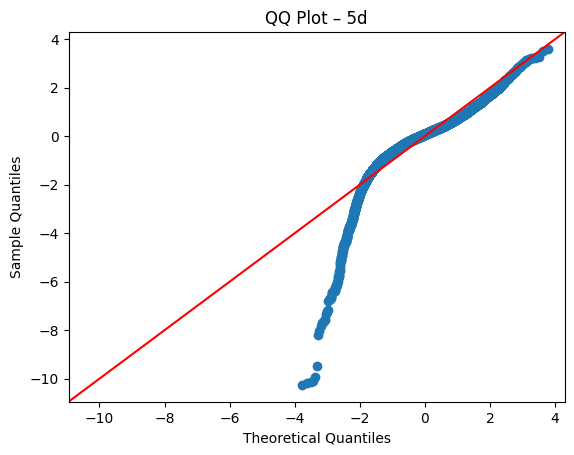

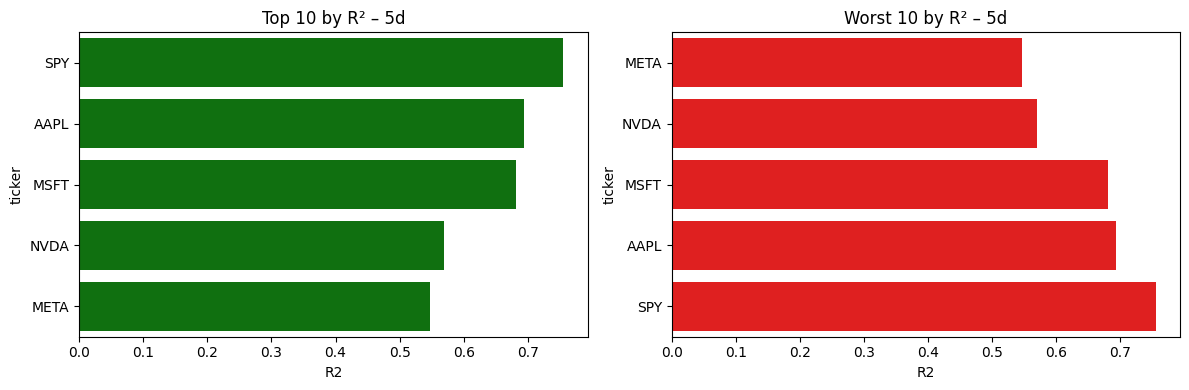

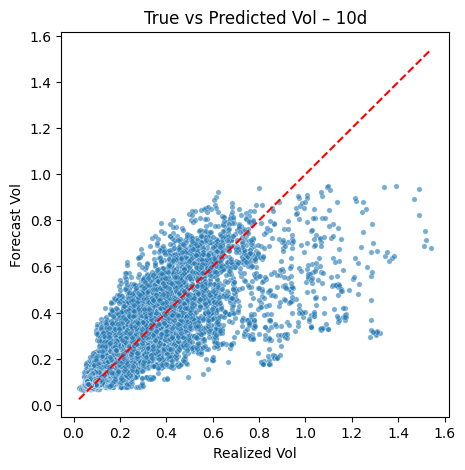

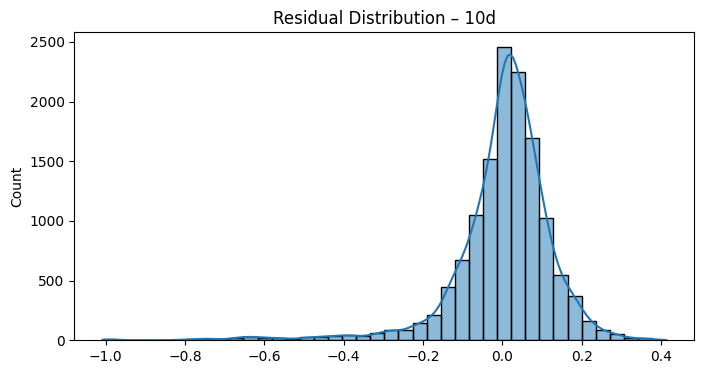

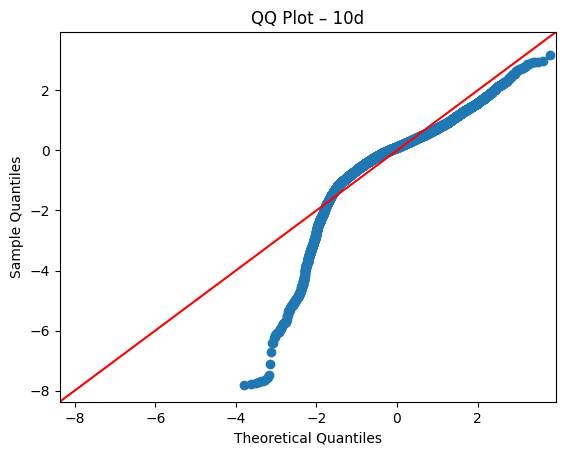

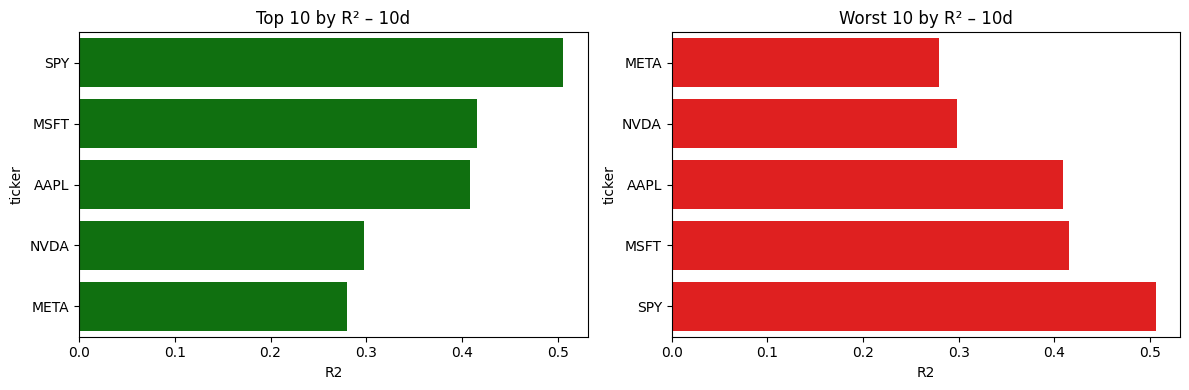

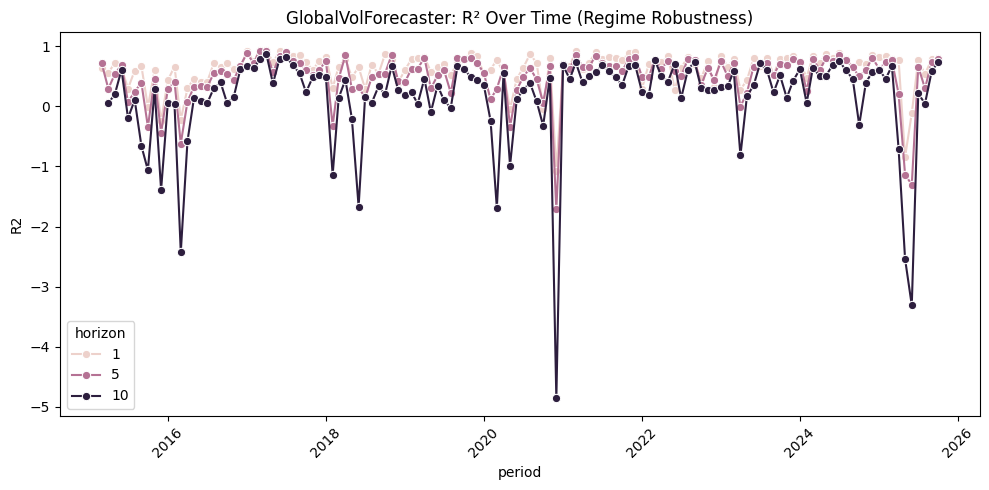

✅ Evaluation complete.


(   ticker  horizon      RMSE       MAE       MAPE        R2      Corr  \
 0    AAPL        1  0.059887  0.045578  18.918058  0.798481  0.910612   
 1    AAPL        5  0.073856  0.053672  22.241939  0.693922  0.838650   
 2    AAPL       10  0.102755  0.073207  30.815460  0.408590  0.655840   
 3    META        1  0.105821  0.071654  22.053086  0.694216  0.835091   
 4    META        5  0.128870  0.084493  25.537126  0.547038  0.745076   
 5    META       10  0.162591  0.107549  32.588186  0.279883  0.554782   
 6    MSFT        1  0.060502  0.044851  20.284028  0.776732  0.896541   
 7    MSFT        5  0.072343  0.053035  24.163800  0.681246  0.828937   
 8    MSFT       10  0.098067  0.070801  32.899206  0.415287  0.659032   
 9    NVDA        1  0.114869  0.079020  18.531994  0.704348  0.841825   
 10   NVDA        5  0.138638  0.092827  21.566788  0.569703  0.757100   
 11   NVDA       10  0.177246  0.123983  29.491058  0.297706  0.558107   
 12    SPY        1  0.049898  0.03312

In [15]:
# Evaluate GlobalVolForecaster model

global_evaluator.run_full_evaluation()


🚀 Running full evaluation for GARCH

📈 Horizon-Level Summary for GARCH


,horizon,RMSE,MAE,MAPE,R2,Corr,DW
0,1,0.0598,0.0454,19.9723,0.7732,0.8901,0.4009


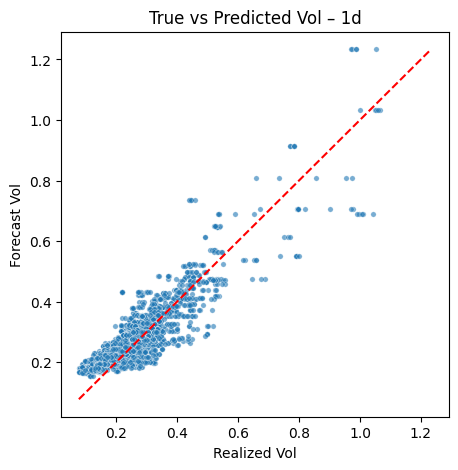

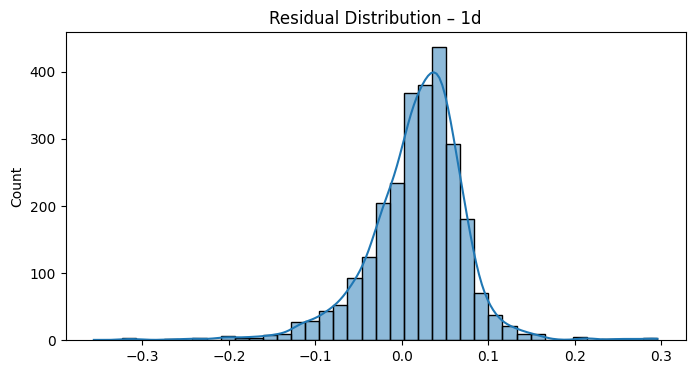

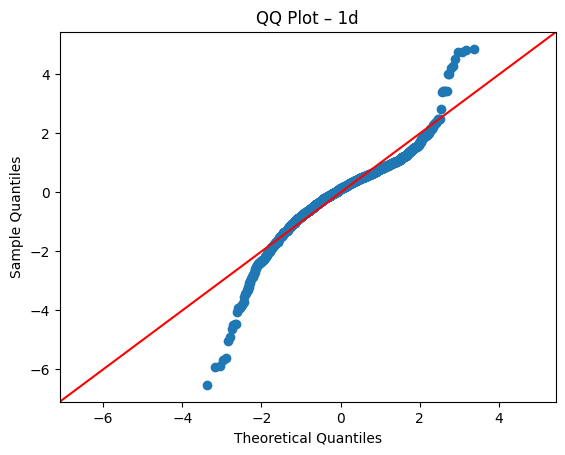

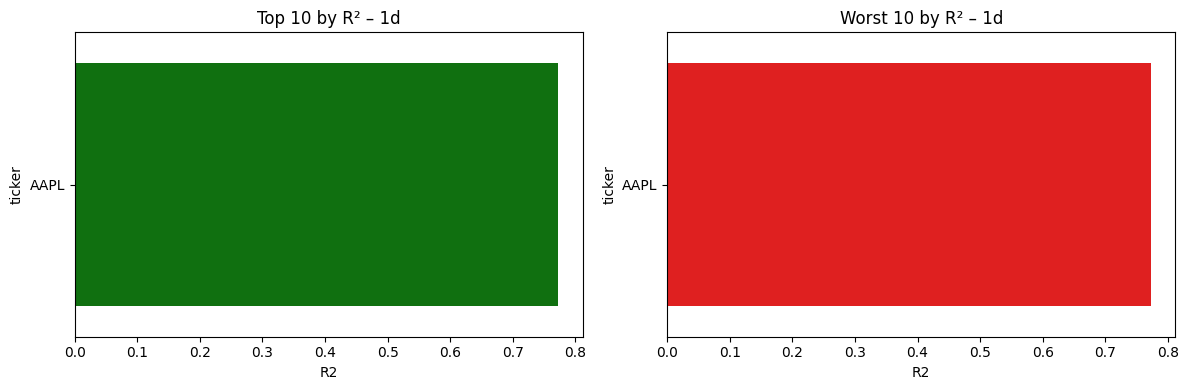

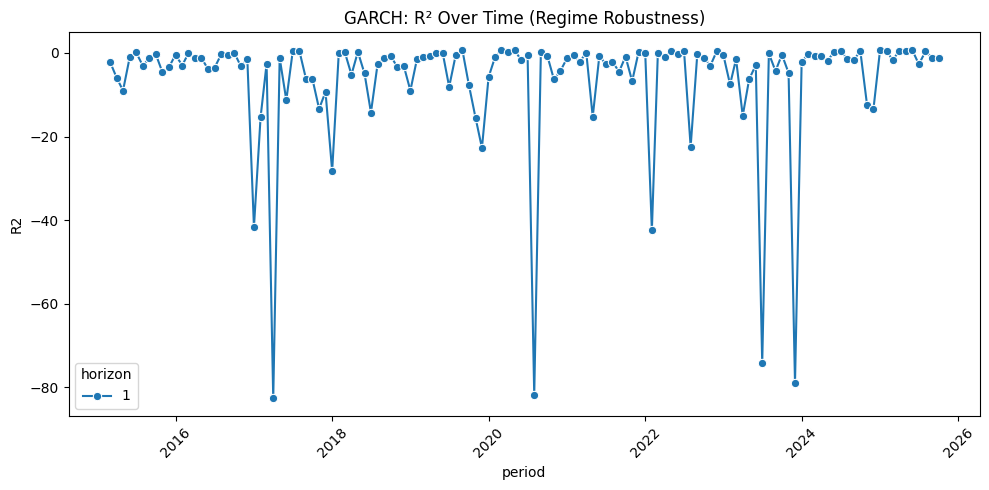

✅ Evaluation complete.


(  ticker  horizon      RMSE       MAE       MAPE        R2      Corr  \
 0   AAPL        1  0.059792  0.045351  19.972305  0.773174  0.890109   
 
          DW  ACF_SumSq  
 0  0.400896   1.473176  ,
    horizon      RMSE       MAE       MAPE        R2      Corr        DW
 0        1  0.059792  0.045351  19.972305  0.773174  0.890109  0.400896,
      horizon     period        R2      Corr      RMSE
 0          1 2015-03-01 -2.102870  0.007137  0.014710
 1          1 2015-04-01 -5.919726  0.786255  0.045381
 2          1 2015-05-01 -9.017002 -0.338393  0.038805
 3          1 2015-06-01 -1.093559  0.803682  0.047913
 4          1 2015-07-01  0.127074  0.718281  0.049136
 ..       ...        ...       ...       ...       ...
 123        1 2025-06-01  0.610947  0.881172  0.034396
 124        1 2025-07-01 -2.737075  0.935469  0.040529
 125        1 2025-08-01  0.366392  0.791285  0.048023
 126        1 2025-09-01 -1.164970 -0.172654  0.041566
 127        1 2025-10-01 -1.186028  0.524740  0

In [16]:
# Evaluate GARCH model 

garch_evaluator.run_full_evaluation()

## 1️⃣6️⃣ An "Apples-to-apples" comparison:

Lets quickly compare all three models and how they performed in predicting AAPL volatility changes for 1-day horizon:

In [ ]:
lstm_aapl_metrics = baselstm_evaluator.compute_metrics()
lstm_aapl_metrics["model_name"] = "BaseLSTM"
lstm_aapl_metrics = lstm_aapl_metrics[lstm_aapl_metrics["horizon"] == 1].copy()

global_evaluator_aapl = ModelEvaluator(
    eval_df=global_preds[global_preds["ticker"] == "AAPL"],
    model_name="GlobalVolForecaster_AAPL",
)

global_aapl_metrics = global_evaluator_aapl.compute_metrics()
global_aapl_metrics["model_name"] = "GlobalVolForecaster"
global_aapl_metrics = global_aapl_metrics[global_aapl_metrics["horizon"] == 1].copy()

garch_aapl_metrics = garch_evaluator.compute_metrics()
garch_aapl_metrics["model_name"] = "GARCH"
garch_aapl_metrics = garch_aapl_metrics[garch_aapl_metrics["horizon"] == 1].copy()

comparison_df = pd.concat(
    [lstm_aapl_metrics, global_aapl_metrics, garch_aapl_metrics],
    axis=0,
    ignore_index=True,
)
cols = ["model_name"] + [c for c in comparison_df.columns if c != "model_name"]
comparison_df = comparison_df[cols]

display(comparison_df)

,model_name,ticker,horizon,RMSE,MAE,MAPE,R2,Corr,DW,ACF_SumSq
0,BaseLSTM,AAPL,1,0.064158,0.047833,3.676952,0.893986,0.955830,0.465572,0.977719
1,GlobalVolForecaster,AAPL,1,0.059887,0.045578,18.918058,0.798481,0.910612,0.222699,3.354055
2,GARCH,AAPL,1,0.059792,0.045351,19.972305,0.773174,0.890109,0.400896,1.473176


## 1️⃣7️⃣ Conclusions

**What we learned**

GARCH family are fast, interpretable baselines that capture volatility clustering.Variants like EGARCH and GJR-GARCH explicitly model asymmetry (leverage) and often improve short-horizon realism when negative shocks dominate.

BaseLSTM leverages a fixed look-back window and engineered features (extra_features) to learn non-linear temporal dependencies, often reducing bias and improving correlation.

GlobalVolForecaster (Global LSTM) shares a single network across tickers, giving it sample efficiency and the ability to learn cross-sectional structure (sector/regime effects).With well-chosen extra_features, it tends to be the best overall performer across horizons.

**Next steps**

Proceed to `03_model_inference.ipynb` for snapshot forecasting, and analytics (`analytics.py`).